# Tutorial 2: Analyzing Statistics and Variogram of the Ice Stream Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs

import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable

### First load data

In [2]:
# load compiled bed elevation measurements
df = pd.read_csv('PineIslandGriddedMASKED_cropped.csv')

In [3]:
df.head()

,Unnamed: 0,x,y,surf,bed,velx,vely,smb,dhdt,final_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
0,29501,-1749750,-389750,197.0,NaN,-38.349506,2.884825,0.164456,0.416048,False,1.0,197.0,3.0,110.019764,-47.0
1,29502,-1749250,-389750,235.0,NaN,-32.821974,2.435352,0.180030,0.421256,False,1.0,235.0,3.0,78.526875,-77.0
2,29503,-1748750,-389750,266.0,NaN,-27.747902,1.805880,0.195604,0.431413,False,1.0,266.0,3.0,40.602303,-95.0
3,29504,-1748250,-389750,292.0,NaN,-23.554756,1.810101,0.211178,0.443132,False,1.0,292.0,3.0,30.169655,-73.0
4,29505,-1747750,-389750,305.0,NaN,-20.156616,1.874327,0.226752,0.446152,False,1.0,305.0,3.0,29.452515,-57.0


In [4]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['final_mask'].values.reshape(xx.shape)

### Now, it is the time to analyze the compiled radar data.

#### Fit variogram

MCMC.fit_variogram is a wrapper around functions in scikit-learn and skgstats python modules. It conveniently normalize the provided bed elevation data, calculate the semi-variogram, and fit it with four different models (Gaussian, Exponential, Spherical, Matern). The output map could be used to visually decide which variogram model fit the data the best.

In [6]:
bedmachine_bed = bedmap_surf - bedmachine_thickness
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmachine_bed)
df['cond_bed'] = cond_bed.flatten()

In [ ]:
# ORIGINAL - DOES NOT WORK

# find variograms
df_bed = df.copy()
df_sampled = df_bed.sample(frac=0.05, random_state=42) # drop out 95% of datapoints
df_bed = df_bed[df_bed["cond_bed"].isnull() == False]
data = df_bed['cond_bed'].values.reshape(-1,1)
coords = df_bed[['x','y']].values
roughness_region_mask = (df_bed['bedmap_mask'].values)==1 # Read BedMachine user guide for the meaning of values == 2 https://nsidc.org/data/nsidc-0756/versions/3

nst_trans, Nbed_radar, varios, fig = MCMC.fit_variogram(data, coords, roughness_region_mask, maxlag=70000, n_lags=10)
# maxlag = 70000, n_lags = 70

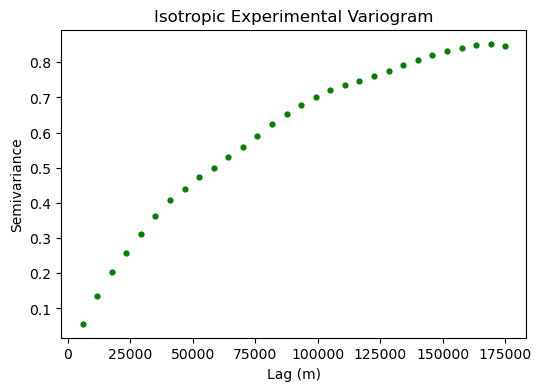

In [7]:
# normal score transformation
df_bed = df.copy()
df_bed = df_bed[df_bed['cond_bed'].isnull() == False]

data = df_bed['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_bed['Nbed'] = nst_trans.transform(data)
Nbed = df_bed['Nbed']

# randomly drop out 95% of coordinates
df_sampled = df_bed.sample(frac=0.05, random_state=42)
df_sampled = df_sampled[df_sampled['bedmap_mask']==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']
maxlag = 175000     # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

# plot
plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

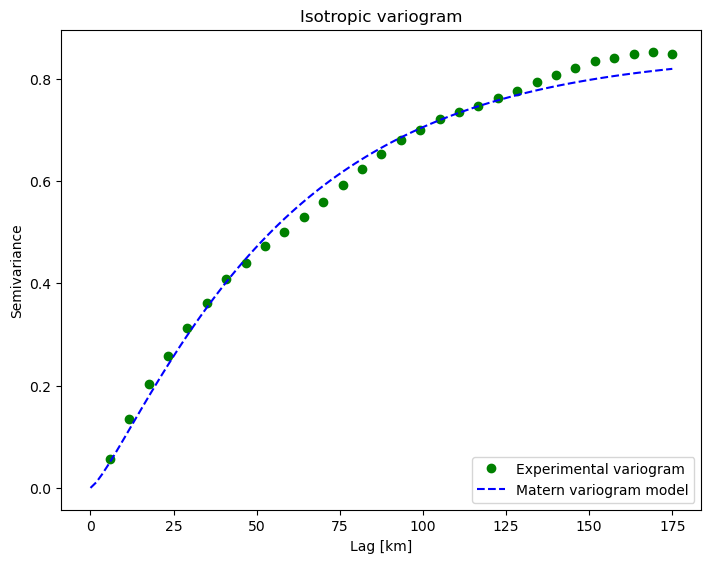

In [8]:
# use matern variogram model
V1.model = 'matern' 
V1.parameters

# evaluate models
xi =np.linspace(0, xdata[-1], 100) 
y_matern = skg.models.matern(xi, V1.parameters[0], V1.parameters[1], V1.parameters[2], V1.parameters[3])

# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_matern,'b--', label='Matern variogram model')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

__Q1: How does the maxlag and n_lags affect variogram calculated? How you determine their values such that your variogram is accurately represented?__

__Q2: Which variogram model you choose? Why?__

#### Generate initial bed

Let's generate a SGS bed for the entire region

https://gatorglaciology.github.io/gstatsimbook/4_Sequential_Gaussian_Simulation.html 

In [9]:
(xx.flatten(),yy.flatten())

(array([-1749750, -1749250, -1748750, ..., -1201750, -1201250, -1200750]),
 array([-389750, -389750, -389750, ...,   29750,   29750,   29750]))

In [10]:
k = 48
rad = 50000
matern = V1.parameters
# [azimuth, nugget, major_range, minor_range, sill, vtype] for anything not Matern 
# [azimuth, nugget, major_range, minor_range, sill, vtype, smoothness] for Matern 
vario = [0, 0, matern[0], matern[0], matern[1], 'Matern', matern[2]]

Pred_grid_xy = df[['x','y']].values

df_bed['Nbed'] = Nbed.values.flatten()

sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_bed, 'x', 'y', 'Nbed', k, vario, rad)


100%|█████████████████████████████████| 923160/923160 [7:00:26<00:00, 36.59it/s]


In [11]:
sgs_bed = nst_trans.inverse_transform(sim.reshape(-1,1)).reshape(xx.shape)
np.savetxt('sgs_bed.txt',sgs_bed)

SGS only generate a realization of the bed topography according to the known radar measurements. However, it might ignored something else. The thickness of the ice can be calculated as ice surface elevation minus bed elevation. From BedMachine, we know where the land is ice-free and where is covered by ice. However, SGS might generate bed such that it 'extrude' out of ice in the supposed grounded ice region. Let's fix that quickly

In [12]:
sgs_bed = np.loadtxt('sgs_bed.txt')

In [13]:
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

There are other things we would like to record before begin the MCMC chains

In [14]:
cond_bed = df['cond_bed'].values.reshape(xx.shape)
data_mask = ~np.isnan(cond_bed)

(0.0, 1099.0, 0.0, 840.0)

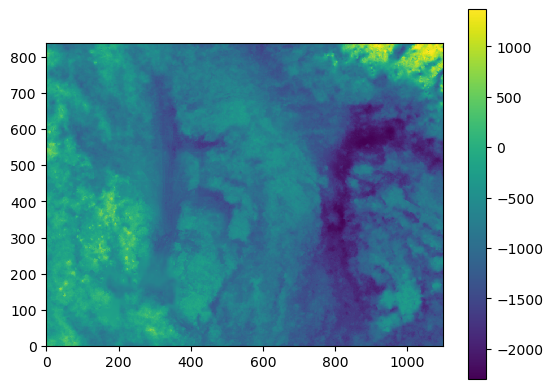

In [15]:
plt.pcolormesh(sgs_bed)
plt.colorbar()
plt.axis('scaled')

(0.0, 1099.0, 0.0, 840.0)

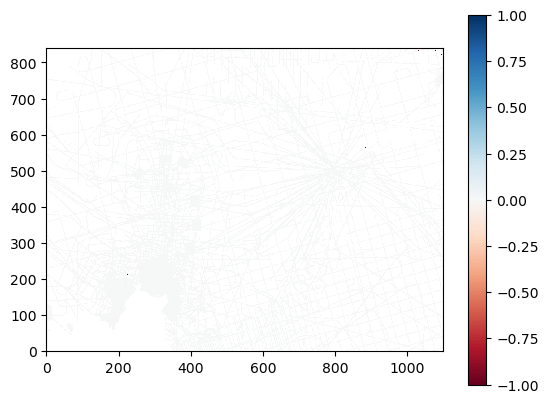

In [16]:
plt.pcolormesh(sgs_bed - cond_bed,vmax=1,vmin=-1,cmap='RdBu')
plt.colorbar()
plt.axis('scaled')